In [1]:
from pathlib import Path
import scipy.io as sio
import numpy as np
import PcmPy as pcm
import matplotlib.pyplot as plt

In [2]:
# directories
glm = 8
base_dir = '/Volumes/diedrichsen_data$/data/SequenceAndChord/OnlinePlanning/op2'
if not Path(base_dir).exists():
    base_dir = '/srv/diedrichsen/data/SequenceAndChord/OnlinePlanning/op2'
roi_dir = base_dir + '/ROI'
glm_dir = base_dir + f'/glm_{glm}'

parcelType = 'Brodmann'
subj_vec = np.arange(22)
nroi = 16
n_cond = 10

data_name = Path(f'{roi_dir}/betas_glm{glm}_{parcelType}_{nroi}ROIs_N={len(subj_vec)}.mat')
T = sio.loadmat(data_name,simplify_cells=True)

In [3]:
Y = list()

roi = 7 # spla
hem = 1 # left hemisphere

for s in subj_vec:
    
    subj_name = "s{:02d}".format(s+1)
    info_name = Path(f'{glm_dir}/{subj_name}/SPM_info.mat')
    
    # spm_info for each subject
    D = sio.loadmat(info_name,simplify_cells=True)

    mask = ((T['ROI_type']==roi) & (T['ROI_side']==hem) & (T['SN']==s+1))
    data = T['betaW'][np.where(mask)][0]

    # get rid of instruction regressor
    data = data[np.where(D['cond']<(n_cond+1))[0],:]

    [cond_vec,part_vec] = pcm.sim.make_design(n_cond,np.int32(data.shape[0]/n_cond))

    obs_des = {'cond_vec': cond_vec,
               'part_vec': part_vec}


    Y.append(pcm.dataset.Dataset(data,obs_descriptors = obs_des))

In [4]:
# Estimate and plot the second moment matrices across all subjects
N=len(Y)
G_hat = np.zeros((N,n_cond,n_cond))
for i in range(0,N):
    G_hat[i,:,:],_ = pcm.est_G_crossval(Y[i].measurements,
                            Y[i].obs_descriptors['cond_vec'],
                            Y[i].obs_descriptors['part_vec'],
                            X=pcm.matrix.indicator(Y[i].obs_descriptors['part_vec']))

In [5]:
T = np.block([[np.zeros((5,5)),np.eye(5)],[np.eye(5),np.zeros((5,5))]])

Gc = np.zeros((2,n_cond,n_cond))

# built the component model based on half of the subjects
Gc[0] = np.mean(G_hat[::2],axis=0)
Gc[1] = T@Gc[0]@T.T

base = np.zeros((1,n_cond,n_cond))
base[0] = np.block([[np.ones((5,5)),np.zeros((5,5))],[np.zeros((5,5)),np.ones((5,5))]])

MF = pcm.model.ModelFamily(Gc,comp_names=['press','cue'],basecomponents=base)

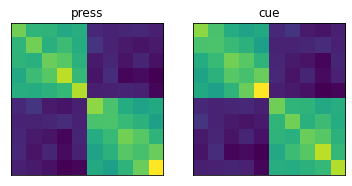

In [6]:
# Show the three model components
for i in range(2):
    ax = plt.subplot(1,2,i+1)
    plt.imshow(Gc[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title(MF.comp_names[i])

<AxesSubplot:xlabel='model', ylabel='Log Bayes Factor'>

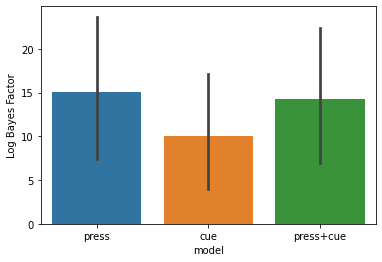

In [7]:
# Fit 
T,theta = pcm.fit_model_individ(Y[1::2],MF,verbose=False,fixed_effect='block',fit_scale=False)
pcm.vis.model_plot(T.likelihood-MF.num_comp_per_m)

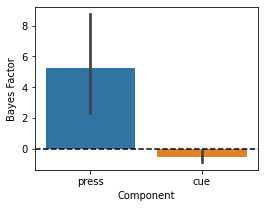

In [8]:
# Component Bayes Factor 
plt.figure(figsize=(4,3))
c_bf = MF.component_bayesfactor(T.likelihood,method='AIC',format='DataFrame')
pcm.vis.plot_component(c_bf,type='bf')